## Multi class MNIST

In [1]:
import sys
sys.path.insert(0, '..')

### MNIST

In [3]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn

from sklearn.metrics import confusion_matrix

In [4]:
from activation import TanH, Sigmoid, ReLU, Softmax
from enums import GradientDescentMode
from linear import Linear
from loss import MSELoss, CELoss
from sequential import Sequential
from optimizers import SGD
from utils import onehot_encoding

In [5]:
def load_mnist(fname="mnist.pkl.gz"):
    f = gzip.open(fname, 'rb')

    if(sys.version_info.major==2):
        train_set, valid_set, test_set = pickle.load(f) # compatibility issue between python 2.7 and 3.4
    else:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin-1') # compatibility issue between python 2.7 and 3.4
    f.close()

    X_train = train_set[0]
    y_train = train_set[1]
    X_val = valid_set[0]
    y_val = valid_set[1]
    X_test = test_set[0]
    y_test = test_set[1]

    train_perm = np.random.permutation(X_train.shape[0])
    X_train = X_train[train_perm,:]
    y_train = y_train[train_perm]

    valid_perm = np.random.permutation(X_val.shape[0])
    X_val = X_val[valid_perm,:]
    y_val = y_val[valid_perm]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
mnist_path = 'data/mnist.pkl.gz'
X_train, y_train, X_val, y_val, X_test, y_test= load_mnist(mnist_path)

In [7]:
print('Train :', X_train.shape, y_train.shape)
print('Validation :', X_val.shape, y_val.shape)
print('Test :', X_test.shape, y_test.shape)

Train : (50000, 784) (50000,)
Validation : (10000, 784) (10000,)
Test : (10000, 784) (10000,)


In [8]:
y_train_onehot = onehot_encoding(y_train, 10)
y_val_onehot = onehot_encoding(y_val, 10)
y_test_onehot = onehot_encoding(y_test, 10)
print('One hot train :', y_train_onehot.shape)
print('One hot val :', y_val_onehot.shape)
print('One hot test :', y_test_onehot.shape)

One hot train : (50000, 10)
One hot val : (10000, 10)
One hot test : (10000, 10)


In [8]:
def show_mnist(data):
    plt.imshow(data.reshape((28,28)),interpolation="nearest")

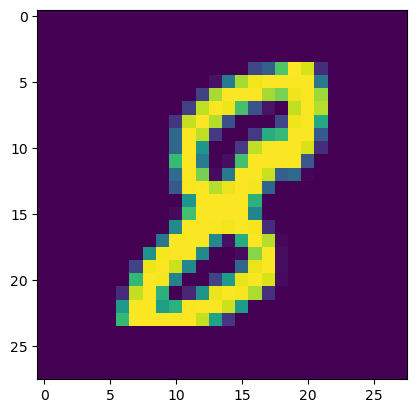

In [9]:
show_mnist(X_train[0])

In [10]:
def eval_fn(net, X_test, y_test):
    y_pred = net(X_test).argmax(1)
    y_test = y_test.argmax(1)
    return np.mean(y_pred == y_test)

### Linear + TanH + Linear + TanH + Linear + CELoss

In [11]:
net = Sequential(
    Linear(28*28, 100),
    TanH(),
    Linear(100, 100),
    TanH(),
    Linear(100, 10),
)

loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    1e-2,
    X_train,
    y_train_onehot,
    10_000,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_val,
    y_val_onehot
)

Train : -----------------------------------
Epoch 1000: train loss: 0.48574405475796395 val loss: 0.4456512861322568 val eval_fn: 0.8913
Epoch 2000: train loss: 0.3665090225453558 val loss: 0.3367914261766133 val eval_fn: 0.9075
Epoch 3000: train loss: 0.3217684432140866 val loss: 0.2978091767446827 val eval_fn: 0.9158
Epoch 4000: train loss: 0.29511682245585585 val loss: 0.27510702136969867 val eval_fn: 0.9218
Epoch 5000: train loss: 0.27560480718746705 val loss: 0.2586018058492956 val eval_fn: 0.9256
Epoch 6000: train loss: 0.2596584545813065 val loss: 0.2450965631009537 val eval_fn: 0.9289
Epoch 7000: train loss: 0.24579068249656247 val loss: 0.23331669011590164 val eval_fn: 0.9325
Epoch 8000: train loss: 0.23332027359467725 val loss: 0.22270875627466108 val eval_fn: 0.9359
Epoch 9000: train loss: 0.22192943806736326 val loss: 0.2130329350139224 val eval_fn: 0.9381
Epoch 10000: train loss: 0.21146363022215994 val loss: 0.20418340553899475 val eval_fn: 0.9423
------------------------

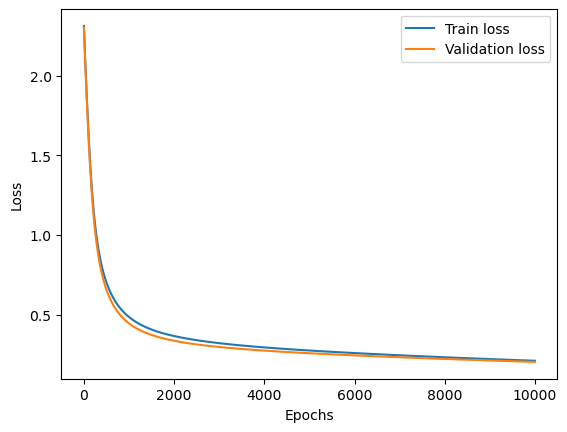

In [12]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

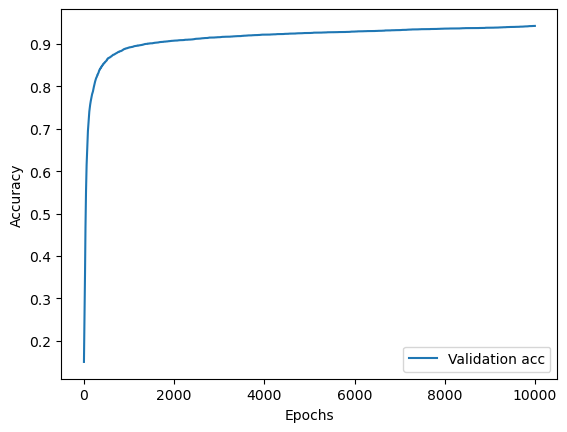

In [13]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, X_test, y_test_onehot))

Test acc : 0.9392


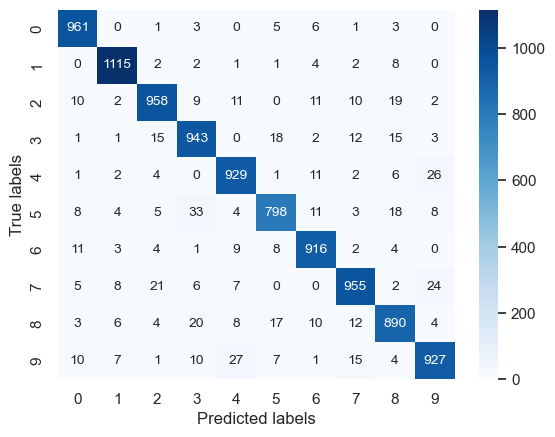

In [15]:
y_pred = net(X_test).argmax(1)
y_test = y_test_onehot.argmax(1)
cm = confusion_matrix(y_test, y_pred)
seaborn.set(font_scale=1) # for label size
seaborn.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g') # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

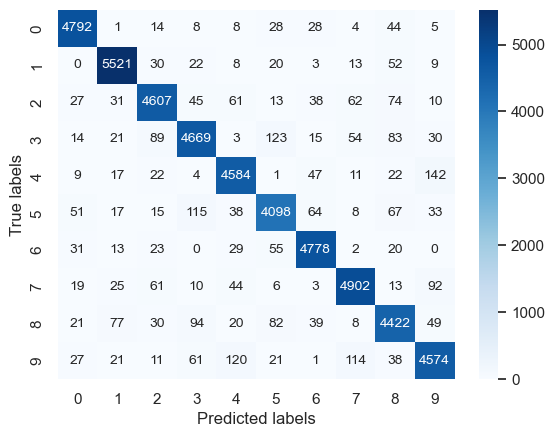

In [17]:
y_pred = net(X_train).argmax(1)
y_train = y_train_onehot.argmax(1)
cm = confusion_matrix(y_train, y_pred)
seaborn.set(font_scale=1) # for label size
seaborn.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g') # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Hidden layers dimension

In [16]:
hiddens = [10, 30, 50, 100, 256]

lr = 1e-1
n_epochs = 1_000

all_loss_ = []
all_loss_valid_ = []
all_acc_valid_ = []
all_acc_test_ = []

for hidden in hiddens:
    print('Hidden layers dimension :', hidden)
    net = Sequential(
        Linear(28*28, hidden),
        TanH(),
        Linear(hidden, hidden),
        TanH(),
        Linear(hidden, 10),
    )
    loss = CELoss()

    all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
        net,
        loss,
        lr,
        X_train,
        y_train_onehot,
        n_epochs,
        GradientDescentMode.BATCH,
        -1,
        eval_fn,
        X_val,
        y_val_onehot
    )

    net.set_parameters(best_parameters)
    acc_test = eval_fn(net, X_test, y_test_onehot)
    print('Test acc :', acc_test)

    all_loss_.append(all_loss)
    all_loss_valid_.append(all_loss_valid)
    all_acc_valid_.append(all_acc_valid)
    all_acc_test_.append(acc_test)
    print()

Hidden layers dimension : 10
Train : -----------------------------------
Epoch 100: train loss: 0.9608329707685013, validation loss: 0.9171418189070504, validation accuracy: 0.8208
Epoch 200: train loss: 0.6259712815444297, validation loss: 0.5880048864875851, validation accuracy: 0.872
Epoch 300: train loss: 0.4998430603447335, validation loss: 0.46650630364819373, validation accuracy: 0.8886
Epoch 400: train loss: 0.4380985782972691, validation loss: 0.40839988592015597, validation accuracy: 0.8965
Epoch 500: train loss: 0.39985746986236925, validation loss: 0.373379033289491, validation accuracy: 0.9021
Epoch 600: train loss: 0.37253269410506046, validation loss: 0.34905764176929577, validation accuracy: 0.9068
Epoch 700: train loss: 0.3514713577983153, validation loss: 0.3308256892614026, validation accuracy: 0.9114
Epoch 800: train loss: 0.3345633132747668, validation loss: 0.31654707547370087, validation accuracy: 0.914
Epoch 900: train loss: 0.3206522585210794, validation loss: 

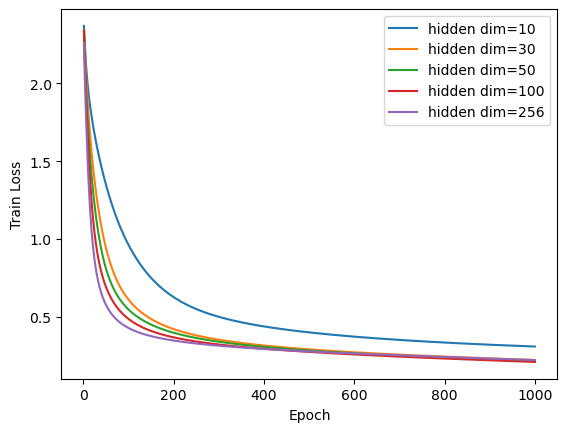

In [17]:
# hidden dim loss
plt.figure()
for i, hidden in enumerate(hiddens):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_[i], label=f'hidden dim={hidden}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

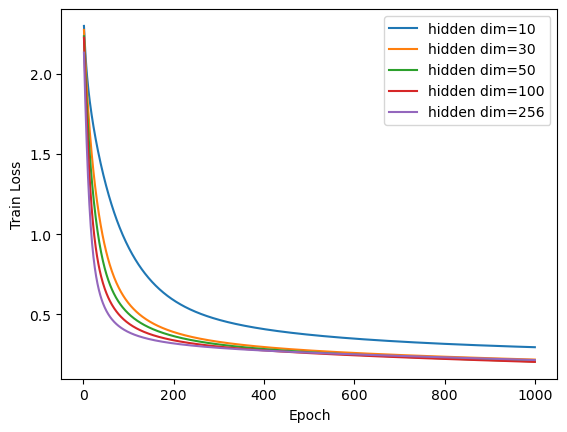

In [18]:
# hidden dim loss validation
plt.figure()
for i, hidden in enumerate(hiddens):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_valid_[i], label=f'hidden dim={hidden}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

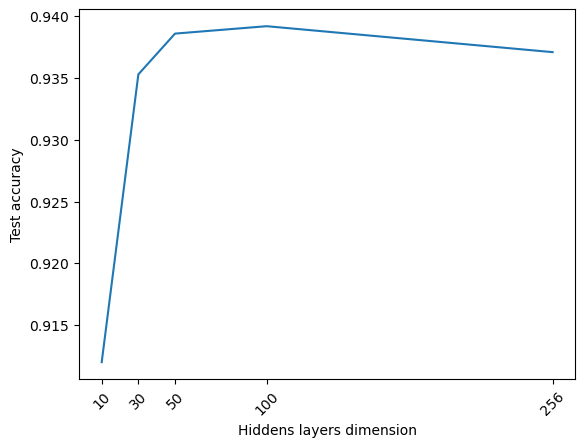

In [19]:
# hidden dim test accuracy
plt.figure()
plt.plot(hiddens, all_acc_test_)
plt.xlabel('Hiddens layers dimension')
plt.ylabel('Test accuracy')
plt.xticks(hiddens, rotation=45)
plt.show()